In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import mpld3
from statsmodels.tsa.api import SimpleExpSmoothing
from sksurv.linear_model import CoxPHSurvivalAnalysis
mpld3.enable_notebook()

In [2]:
#Read Data frame
df_original = pd.read_csv('SteamCharts.csv')
df = df_original.copy()

/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,27,29,31,52,67,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Replace nan with -1
df = df.replace(np.nan,-1)

#Select peak players from df
df = df.loc[df['Peak_Players'] == 1]

In [4]:
#Convert values to floats
df.columns.values[6:]
for i in df.columns.values[6:]:
    df[i]=df[i].astype(float)

In [5]:
#More data treatment
lista = []
minimum_peak = 100
for i in df.index:
    if (df.loc[i].values[6:].max() == 0) or (df.loc[i].values[6:].max() < minimum_peak):
        lista.append(i)

df = df.drop(lista)
df = df.drop(df.loc[df['April 2021'] == -1].index)
df = df.rename(columns={"Last 30 Days": "May 2021"}, errors="raise")

In [6]:
#Exponential fit on data
#This block replaces the values of the df with new exponential fit


df_dummy_right = df.drop(columns = ['Name', 'App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players']).copy()
df_dummy_left = df.drop(columns = df.columns[6:]).copy()


def Reverse(lst):
    return [ele for ele in reversed(lst)]


for index in df_dummy_right.index:
    
    a = list(df_dummy_right.loc[index])
    b = np.arange(0,len(a))
    arr = np.array(Reverse(a))
    ses = SimpleExpSmoothing(arr)
    fit = ses.fit(smoothing_level = .3 , optimized=False)
    fitlist = list(fit.fittedvalues)
    fitlistrev = Reverse(fitlist)
    df_dummy_right.loc[index] = fitlistrev



df = pd.concat([df_dummy_left, df_dummy_right], axis=1)




/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [7]:
#Find how long it takes to reach maximum

def days_to_glory(index):
#Find when it was released
    c = 0
    flag = False
    for i in list(df.loc[index].values):
        if (type(i) == type(np.array([.1])[0])):
            if i < 0:
                release =  pd.Timestamp(df.columns[c-1]) 
                flag = True
                break
        c +=1
    if flag == False:
        release = pd.Timestamp(df.columns[-1]) 
#Find when it reached maximum
    c = -1 
    for i in reversed(list(df.loc[index].values)):
        if i == df.loc[index].values[6:].max():
       
            maximum = pd.Timestamp(df.columns[c])
            break
        c -= 1
    
    x = str(maximum - release)
    return float(x.split(' ')[0])


In [8]:
#Find how long it takes to reach 10% once maximum is reached

perc = .10 #This number controls the percentage desired

def life_time(index):
    c = -1 
    for i in reversed(list(df.loc[index].values)):
        if i == df.loc[index].values[6:].max():
    
            maximum = pd.Timestamp(df.columns[c])
            break
        c -= 1 
    trunc = df.loc[index].values[:(c+len(df.loc[index].values))]
    trunc = trunc[6:]
    d = -1 
    flag = False
    for i in reversed(list(trunc)):        
        if i <= df.loc[index].values[6:].max()*perc:  
            death = pd.Timestamp(df.columns[d+c])
            flag = True
            break
        d -= 1 
    if flag == False:
        x = str(pd.Timestamp('May 2021') - maximum)
        return float(x.split(' ')[0]) , False
    else:
        x = str(death - maximum)
        return float(x.split(' ')[0]) , True


In [9]:

days = [] #Days to reach maximum
games_alive = [] #Games that are "alive", which are the games that have not died by May 2021
bad_index = [] #Index of games that miss data
c = 0
for index in df.index:
    #print(c/len(df.index)*100)
    c += 1
    if days_to_glory(index) >= 0:
        days.append(days_to_glory(index))
    if days_to_glory(index) == 0:
        games_alive.append(index)
    if days_to_glory(index) < 0:
        bad_index.append(index)
    
df = df.drop(bad_index)


In [10]:
life = [] #How long the games last to reach the desired percentage
#False means alive
status = []
c = 0
for index in df.index:
    #print(c/len(df.index)*100)
    life.append(life_time(index)[0])
    status.append(life_time(index)[1])
    c += 1


0.0
0.01656726308813784
0.03313452617627568
0.049701789264413515
0.06626905235255136
0.08283631544068919
0.09940357852882703
0.11597084161696489
0.13253810470510272
0.14910536779324055
0.16567263088137837
0.18223989396951623
0.19880715705765406
0.21537442014579194
0.23194168323392977
0.2485089463220676
0.26507620941020543
0.28164347249834326
0.2982107355864811
0.3147779986746189
0.33134526176275675
0.34791252485089463
0.36447978793903246
0.3810470510271703
0.3976143141153081
0.414181577203446
0.4307488402915839
0.44731610337972166
0.46388336646785955
0.4804506295559973
0.4970178926441352
0.513585155732273
0.5301524188204109
0.5467196819085487
0.5632869449966865
0.5798542080848245
0.5964214711729622
0.6129887342611001
0.6295559973492378
0.6461232604373758
0.6626905235255135
0.6792577866136514
0.6958250497017893
0.7123923127899271
0.7289595758780649
0.7455268389662028
0.7620941020543406
0.7786613651424784
0.7952286282306162
0.8117958913187541
0.828363154406892
0.8449304174950298
0.861497

7.455268389662027
7.4718356527501655
7.488402915838304
7.504970178926442
7.521537442014579
7.538104705102717
7.5546719681908545
7.571239231278993
7.58780649436713
7.604373757455268
7.620941020543406
7.637508283631544
7.654075546719683
7.670642809807819
7.687210072895957
7.703777335984095
7.7203445990722335
7.736911862160372
7.75347912524851
7.770046388336647
7.786613651424784
7.8031809145129225
7.81974817760106
7.836315440689198
7.852882703777336
7.869449966865474
7.886017229953611
7.902584493041749
7.919151756129887
7.935719019218025
7.952286282306163
7.9688535453943015
7.98542080848244
8.001988071570576
8.018555334658714
8.035122597746852
8.05168986083499
8.068257123923129
8.084824387011267
8.101391650099403
8.117958913187541
8.13452617627568
8.151093439363818
8.167660702451956
8.184227965540094
8.20079522862823
8.217362491716369
8.233929754804507
8.250497017892645
8.267064280980781
8.28363154406892
8.300198807157058
8.316766070245194
8.333333333333332
8.34990059642147
8.366467859509

14.943671305500331
14.96023856858847
14.976805831676607
14.993373094764745
15.009940357852884
15.026507620941022
15.043074884029158
15.059642147117296
15.076209410205434
15.092776673293573
15.109343936381709
15.125911199469847
15.142478462557985
15.159045725646122
15.17561298873426
15.192180251822398
15.208747514910536
15.225314777998674
15.241882041086813
15.25844930417495
15.275016567263089
15.291583830351227
15.308151093439365
15.324718356527503
15.341285619615638
15.357852882703776
15.374420145791914
15.390987408880052
15.40755467196819
15.424121935056329
15.440689198144467
15.457256461232605
15.473823724320743
15.490390987408881
15.50695825049702
15.523525513585156
15.540092776673294
15.55666003976143
15.573227302849569
15.589794565937707
15.606361829025845
15.622929092113983
15.63949635520212
15.656063618290258
15.672630881378396
15.689198144466534
15.705765407554672
15.72233267064281
15.738899933730949
15.755467196819087
15.772034459907221
15.78860172299536
15.805168986083498
15

22.39893969516236
22.415506958250496
22.432074221338635
22.448641484426773
22.46520874751491
22.48177601060305
22.498343273691187
22.514910536779322
22.53147779986746
22.548045062955598
22.564612326043736
22.581179589131875
22.597746852220013
22.61431411530815
22.63088137839629
22.647448641484427
22.664015904572565
22.680583167660703
22.69715043074884
22.71371769383698
22.730284956925114
22.746852220013253
22.76341948310139
22.77998674618953
22.796554009277667
22.813121272365805
22.829688535453943
22.84625579854208
22.86282306163022
22.879390324718358
22.895957587806496
22.912524850894634
22.929092113982772
22.945659377070907
22.962226640159045
22.978793903247183
22.99536116633532
23.01192842942346
23.028495692511598
23.045062955599736
23.061630218687874
23.078197481776012
23.09476474486415
23.11133200795229
23.127899271040427
23.144466534128565
23.1610337972167
23.177601060304838
23.194168323392976
23.210735586481114
23.227302849569252
23.24387011265739
23.26043737574553
23.2770046388

29.7713717693837
29.787939032471833
29.804506295559975
29.82107355864811
29.83764082173625
29.854208084824386
29.870775347912527
29.887342611000662
29.903909874088804
29.92047713717694
29.93704440026508
29.953611663353215
29.970178926441353
29.98674618952949
30.003313452617626
30.019880715705767
30.036447978793902
30.053015241882044
30.069582504970178
30.086149768058316
30.102717031146454
30.119284294234593
30.13585155732273
30.15241882041087
30.168986083499007
30.185553346587145
30.20212060967528
30.218687872763418
30.235255135851556
30.251822398939694
30.268389662027833
30.28495692511597
30.30152418820411
30.318091451292243
30.334658714380385
30.35122597746852
30.36779324055666
30.384360503644796
30.400927766732938
30.417495029821072
30.434062292909214
30.45062955599735
30.467196819085483
30.483764082173625
30.50033134526176
30.5168986083499
30.533465871438036
30.550033134526178
30.566600397614312
30.583167660702454
30.59973492379059
30.61630218687873
30.632869449966865
30.6494367130

37.22664015904573
37.243207422133864
37.259774685222006
37.27634194831014
37.29290921139828
37.30947647448642
37.32604373757455
37.34261100066269
37.35917826375083
37.37574552683897
37.392312789927104
37.408880053015245
37.42544731610338
37.44201457919152
37.458581842279656
37.47514910536779
37.49171636845593
37.50828363154407
37.52485089463221
37.541418157720344
37.55798542080848
37.57455268389662
37.591119946984755
37.607687210072896
37.62425447316103
37.64082173624917
37.65738899933731
37.67395626242545
37.69052352551358
37.70709078860172
37.72365805168986
37.740225314777994
37.756792577866136
37.77335984095427
37.78992710404241
37.80649436713055
37.82306163021869
37.83962889330682
37.85619615639496
37.8727634194831
37.889330682571234
37.905897945659376
37.92246520874751
37.93903247183565
37.95559973492379
37.97216699801193
37.98873426110006
38.005301524188205
38.02186878727634
38.03843605036448
38.055003313452616
38.07157057654075
38.08813783962889
38.10470510271703
38.121272365805

44.731610337972164
44.748177601060306
44.76474486414844
44.78131212723658
44.79787939032472
44.81444665341285
44.83101391650099
44.84758117958913
44.86414844267727
44.880715705765404
44.897282968853546
44.91385023194168
44.93041749502982
44.94698475811796
44.9635520212061
44.98011928429423
44.996686547382374
45.01325381047051
45.029821073558644
45.046388336646785
45.06295559973492
45.07952286282306
45.096090125911196
45.11265738899934
45.12922465208747
45.145791915175614
45.16235917826375
45.17892644135189
45.195493704440025
45.21206096752817
45.2286282306163
45.245195493704436
45.26176275679258
45.27833001988071
45.294897282968854
45.31146454605699
45.32803180914513
45.344599072233265
45.36116633532141
45.37773359840954
45.39430086149768
45.41086812458582
45.42743538767396
45.444002650762094
45.46056991385023
45.47713717693837
45.493704440026505
45.51027170311465
45.52683896620278
45.54340622929092
45.55997349237906
45.5765407554672
45.593108018555334
45.609675281643476
45.62624254473

52.352551358515576
52.36911862160372
52.385685884691846
52.40225314777999
52.41882041086813
52.43538767395626
52.4519549370444
52.46852220013254
52.48508946322068
52.50165672630881
52.51822398939695
52.53479125248509
52.551358515573234
52.56792577866136
52.584493041749504
52.601060304837645
52.61762756792577
52.634194831013914
52.650762094102056
52.6673293571902
52.683896620278325
52.70046388336647
52.71703114645461
52.73359840954275
52.75016567263088
52.76673293571902
52.78330019880716
52.7998674618953
52.81643472498343
52.83300198807157
52.849569251159714
52.86613651424784
52.88270377733598
52.899271040424125
52.91583830351227
52.932405566600394
52.948972829688536
52.96554009277668
52.98210735586481
52.99867461895295
53.01524188204109
53.03180914512923
53.04837640821736
53.0649436713055
53.08151093439364
53.09807819748178
53.11464546056991
53.13121272365805
53.147779986746194
53.16434724983433
53.18091451292246
53.197481776010605
53.21404903909874
53.23061630218688
53.247183565275016

59.95692511597084
59.97349237905898
59.990059642147116
60.00662690523525
60.02319416832339
60.039761431411534
60.05632869449967
60.072895957587804
60.089463220675945
60.10603048376409
60.12259774685222
60.139165009940356
60.1557322730285
60.17229953611663
60.188866799204774
60.20543406229291
60.222001325381044
60.238568588469185
60.25513585155732
60.27170311464546
60.288270377733596
60.30483764082174
60.32140490390987
60.337972166998014
60.35453943008615
60.37110669317429
60.387673956262425
60.40424121935056
60.4208084824387
60.437375745526836
60.45394300861497
60.47051027170311
60.487077534791254
60.50364479787939
60.52021206096752
60.536779324055665
60.55334658714381
60.56991385023194
60.586481113320076
60.60304837640822
60.61961563949636
60.63618290258449
60.65275016567263
60.66931742876077
60.6858846918489
60.70245195493704
60.71901921802518
60.73558648111332
60.75215374420145
60.76872100728959
60.785288270377734
60.801855533465876
60.818422796554
60.834990059642145
60.851557322730

67.61100066269053
67.62756792577866
67.6441351888668
67.66070245195493
67.67726971504308
67.69383697813122
67.71040424121935
67.72697150430749
67.74353876739563
67.76010603048377
67.7766732935719
67.79324055666004
67.80980781974819
67.82637508283631
67.84294234592446
67.85950960901259
67.87607687210073
67.89264413518886
67.90921139827701
67.92577866136514
67.94234592445328
67.95891318754141
67.97548045062956
67.9920477137177
68.00861497680583
68.02518223989397
68.04174950298211
68.05831676607025
68.07488402915838
68.09145129224652
68.10801855533467
68.1245858184228
68.14115308151094
68.15772034459907
68.1742876076872
68.19085487077535
68.20742213386349
68.22398939695162
68.24055666003976
68.2571239231279
68.27369118621604
68.29025844930418
68.30682571239231
68.32339297548044
68.33996023856858
68.35652750165673
68.37309476474486
68.389662027833
68.40622929092113
68.42279655400928
68.43936381709742
68.45593108018555
68.47249834327368
68.48906560636183
68.50563286944997
68.5222001325381
6

75.23194168323393
75.24850894632206
75.26507620941021
75.28164347249835
75.29821073558648
75.31477799867461
75.33134526176276
75.3479125248509
75.36447978793903
75.38104705102717
75.39761431411532
75.41418157720344
75.43074884029159
75.44731610337972
75.46388336646785
75.48045062955599
75.49701789264414
75.51358515573227
75.5301524188204
75.54671968190854
75.56328694499669
75.57985420808483
75.59642147117296
75.6129887342611
75.62955599734924
75.64612326043738
75.66269052352551
75.67925778661365
75.6958250497018
75.71239231278992
75.72895957587806
75.7455268389662
75.76209410205435
75.77866136514247
75.79522862823062
75.81179589131875
75.8283631544069
75.84493041749502
75.86149768058317
75.8780649436713
75.89463220675944
75.91119946984757
75.92776673293572
75.94433399602386
75.96090125911199
75.97746852220013
75.99403578528828
76.01060304837641
76.02717031146454
76.04373757455268
76.06030483764083
76.07687210072896
76.0934393638171
76.11000662690523
76.12657388999338
76.1431411530815
7

82.98542080848243
83.00198807157058
83.01855533465871
83.03512259774686
83.05168986083498
83.06825712392313
83.08482438701127
83.1013916500994
83.11795891318754
83.13452617627568
83.15109343936382
83.16766070245195
83.18422796554009
83.20079522862824
83.21736249171637
83.2339297548045
83.25049701789264
83.26706428098079
83.28363154406891
83.30019880715706
83.3167660702452
83.33333333333334
83.34990059642146
83.36646785950961
83.38303512259775
83.3996023856859
83.41616964877402
83.43273691186216
83.4493041749503
83.46587143803845
83.48243870112657
83.49900596421472
83.51557322730285
83.53214049039099
83.54870775347912
83.56527501656727
83.5818422796554
83.59840954274354
83.61497680583167
83.63154406891982
83.64811133200796
83.66467859509609
83.68124585818423
83.69781312127238
83.7143803843605
83.73094764744864
83.74751491053678
83.76408217362493
83.78064943671305
83.7972166998012
83.81378396288933
83.83035122597747
83.8469184890656
83.86348575215375
83.88005301524188
83.89662027833002
8

90.72233267064281
90.73889993373095
90.75546719681908
90.77203445990722
90.78860172299537
90.8051689860835
90.82173624917164
90.83830351225977
90.85487077534792
90.87143803843605
90.88800530152419
90.90457256461232
90.92113982770046
90.9377070907886
90.95427435387674
90.97084161696488
90.98740888005301
91.00397614314116
91.0205434062293
91.03711066931743
91.05367793240556
91.0702451954937
91.08681245858185
91.10337972166998
91.11994698475812
91.13651424784625
91.1530815109344
91.16964877402253
91.18621603711067
91.2027833001988
91.21935056328695
91.23591782637507
91.25248508946322
91.26905235255136
91.2856196156395
91.30218687872762
91.31875414181577
91.33532140490391
91.35188866799204
91.36845593108018
91.38502319416833
91.40159045725646
91.4181577203446
91.43472498343273
91.45129224652088
91.46785950960901
91.48442677269715
91.50099403578528
91.51756129887343
91.53412856196155
91.5506958250497
91.56726308813784
91.58383035122598
91.6003976143141
91.61696487740225
91.63353214049039
91

98.42611000662691
98.44267726971503
98.45924453280318
98.47581179589132
98.49237905897945
98.50894632206759
98.52551358515574
98.54208084824387
98.558648111332
98.57521537442014
98.59178263750829
98.60834990059642
98.62491716368456
98.64148442677269
98.65805168986084
98.67461895294898
98.69118621603711
98.70775347912524
98.7243207422134
98.74088800530151
98.75745526838966
98.7740225314778
98.79058979456595
98.80715705765407
98.82372432074222
98.84029158383035
98.8568588469185
98.87342611000662
98.88999337309477
98.9065606361829
98.92312789927104
98.93969516235917
98.95626242544732
98.97282968853546
98.98939695162359
99.00596421471172
99.02253147779987
99.03909874088801
99.05566600397614
99.07223326706428
99.08880053015243
99.10536779324056
99.1219350563287
99.13850231941683
99.15506958250498
99.1716368455931
99.18820410868125
99.20477137176938
99.22133863485753
99.23790589794565
99.2544731610338
99.27104042412194
99.28760768721008
99.3041749502982
99.32074221338635
99.33730947647449
99

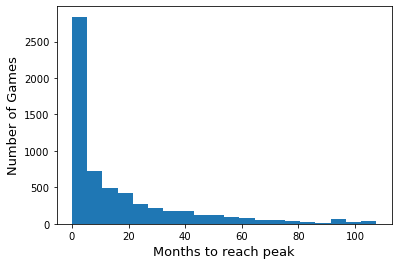

In [11]:
#Histogram 1

months = np.array(days)/30
plt.hist(months,20)
plt.xlabel('Months to reach peak', fontsize = 13)
plt.ylabel('Number of Games', fontsize = 13)

plt.savefig('reach_peak.png')
plt.show()

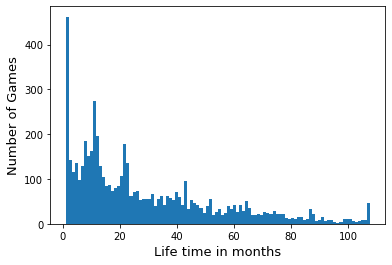

In [12]:
# Histogram 2
life = np.array(life)
plt.hist(life[life>0]/30,100,)
plt.xlabel('Life time in months', fontsize = 13)
plt.ylabel('Number of Games', fontsize = 13)
plt.savefig('life_time.png')
plt.show()

In [13]:
lofe = life/30
lofe = lofe[lofe>6]
lofe = lofe[lofe>0]
print('The total number of games that died after 6 months is ', len(lofe))

The total number of games that died after 6 months is  4718


In [14]:
lofe = life/30
lofe = lofe[lofe<=6]
lofe = lofe[lofe>0]
print('The total number of games that died before 6 months is ', len(lofe))

The total number of games that died before 6 months is  856


In [15]:
print('the number of games alive containing at least peak ', minimum_peak, 'is ', len(games_alive))

#### app id for the games
block_busters = df.loc[games_alive]


the number of games containing at least peak  100 is  881


In [16]:
#Status: if status is True, it means that the game died. If it is False, it means that the game is still alive.

df['Status'] = status
df['Life_time'] = life
df['Days_to_glory'] = days

Text(0, 0.5, 'Life time Days')

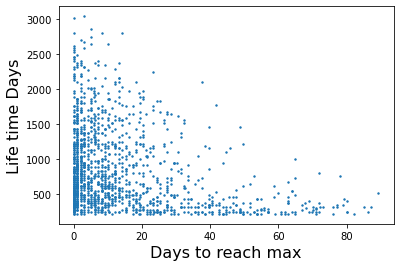

In [17]:
# Scatter Plot
temp = df.loc[ df['Status'] == True ][['Days_to_glory','Life_time']]
plt.scatter(temp['Days_to_glory']/30, temp['Life_time'], s = 2)
plt.xlabel("Days to reach max", fontsize = 16)
plt.ylabel("Life time Days", fontsize = 16)

/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


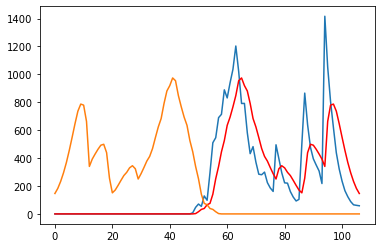

In [20]:
#Example of how fitted data looks
    
a = list(df_dummy_right.loc[50067])
b = np.arange(0,len(a))
arr = np.array(Reverse(a))
ses = SimpleExpSmoothing(arr)
fit = ses.fit(smoothing_level = .3 , optimized=False)
fitlist = list(fit.fittedvalues)
fitlistrev = Reverse(fitlist)



pd.concat([df_dummy_left, df_dummy_right], axis=1)



plt.plot(b,Reverse(a))

plt.plot(b, fit.fittedvalues,'r-', label = "Fitted Values")

plt.plot(b,fitlistrev)

## Survival  Probability

In [21]:
data_y = df[['App_id','Status','Life_time']]

Text(0.5, 0, 'Time in Months')

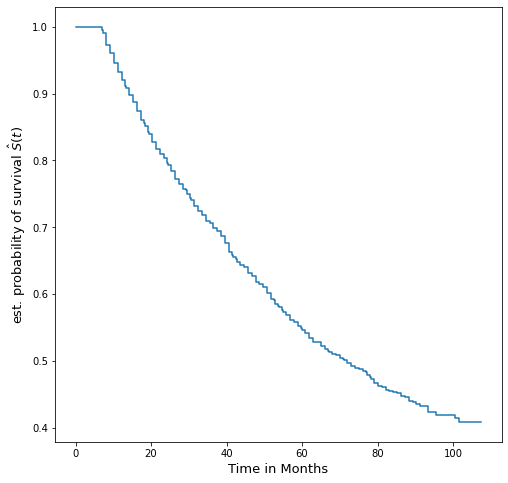

In [46]:
#Use Kaplan Meier Estimator to calculate survival probability using only the survival times and status.

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Life_time"]/30)
plt.figure(figsize=(8,8))
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$",  fontsize = 13)
plt.xlabel("Time in Months", fontsize = 13)

In [23]:
#Bring data frame with features
all_data_original = pd.read_csv('AllData.csv')
all_data_dummy = all_data_original.copy()

#Convert Categorical data to numeric data
for i in all_data_dummy.columns[19:54]:
    all_data_dummy[i] = all_data_dummy[i].astype(int)

print('the original number of games for all data was ',len(all_data_original))

the original number of games for all data was  10576


In [24]:
#Merge to match games from life times
app_id = df['App_id']
all_data = all_data_dummy.merge(app_id, how = 'inner', on = 'App_id')


6036 5679


In [25]:
#Make data_x

#Drop non numeric data
data_x = all_data.drop(columns = ['App_id', 'Name', 'ReleaseDate', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
                         'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency', 
                         'SupportEmail','SupportURL', 'AboutText','Background', 'ShortDescrip', 
                         'DetailedDescrip', 'DRMNotice','ExtUserAcctNotice', 'HeaderImage', 
                         'LegalNotice', 'Reviews','SupportedLanguages', 'Website', 'PCMinReqsText', 
                         'PCRecReqsText','LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText', 
                         'MacRecReqsText'])

data_x = data_x.drop(columns=[ 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'SteamSpyOwnersNew',
                              'peak_max', 'peak_mean', 'max', 'mean'])




In [26]:
data_y  = data_y.merge(all_data, how = 'right', on = 'App_id')
data_y = data_y[['Status','Life_time']]


# Change format of data_y to structural array
struc = []
for i in data_y.values:
    struc.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc = np.array(struc, dtype = dt)


In [27]:
#new data frame to be used for cross validation. 
cvdf = data_x.copy()
cvdf['Status'] = data_y['Status']
cvdf['Life_time'] = data_y['Life_time']

cvdf_train = cvdf.sample(int(len(cvdf)*.75)).copy()
cvdf_test= cvdf.drop(cvdf_train.index).copy()




In [28]:
#Cross validation to find optimal regularization (alpha)

from sklearn.base import clone
from sklearn.model_selection import KFold



estimator = CoxPHSurvivalAnalysis()

alpha_val = np.arange(0,30)

scores = np.empty((3,len(alpha_val)))



def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

kfold = KFold(n_splits = 3, shuffle = True, random_state = 440)


i = 0

for train_index, test_index in kfold.split(cvdf_train):
## For each possible model
    ## get X and y
    
    for j in range(len(alpha_val)):
    
        X, y = get_X_y(cvdf_train, cvdf_train.columns[:46], ['Status','Life_time'])


        # Get the cv train test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        struc_train = []
        for k in y_train:
            struc_train.append((k[0],k[1]))
        dt = np.dtype('bool,float')
        struc_train = np.array(struc_train, dtype = dt)

        struc_test = []
        for k in y_test:
            struc_test.append((k[0],k[1]))
        dt = np.dtype('bool,float')
        struc_test = np.array(struc_test, dtype = dt)

        # Cloning the regression makes a fresh regression 
        # model for each run
        clone_estimator = clone(estimator)

        estimator = CoxPHSurvivalAnalysis(alpha = j)


        # fit the model
        clone_estimator.fit(X_train, struc_train)

        clone_estimator.score(X_test, struc_test)

        scores[i,j] = clone_estimator.score(X_test, struc_test)

    
    ## We'll now move to the next split
    i = i + 1



/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=7.20681e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=2.65124e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=7.20681e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=2.65124e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/Users/eduardomedina/opt/anaconda3/lib/pytho

In [29]:
# Find optimal regularization
np.argmax(np.mean(scores, axis = 0))

print("The model with the highest score CV ",
     "was the one with alpha = ", alpha_val[np.argmax(np.mean(scores, axis = 0))],
     ". This model had a score CV of", np.round(np.max(np.mean(scores, axis=0)),5))


The model with the highest score CV  was the one with alpha =  2 . This model had a score CV of 0.62062


In [31]:
#Fit using optimal regularization
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha = alpha_val[np.argmax(np.mean(scores, axis = 0))])

struc_train = []
for i in cvdf_train[['Status','Life_time']].values:
    struc_train.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc_train = np.array(struc_train, dtype = dt)


estimator.fit(cvdf_train[cvdf_train.columns[:46]], struc_train)



CoxPHSurvivalAnalysis(alpha=2)

In [32]:
# The value of these coefficients tell us the weight of each feature and their impact.
# Coeff > 0 contributes to decrease the probaility of survival
# Coeff < 0 increases probability of survival
pd.Series(estimator.coef_, index=data_x.columns)


RequiredAge                   -0.005496
DemoCount                     -0.004379
DeveloperCount                 0.016440
DLCCount                      -0.001500
Metacritic                    -0.000472
MovieCount                     0.058686
PackageCount                   0.081386
RecommendationCount           -0.000004
PublisherCount                -0.393369
ScreenshotCount               -0.000014
AchievementCount               0.000010
AchievementHighlightedCount    0.013829
ControllerSupport              0.132190
IsFree                         0.060276
FreeVerAvail                   1.062987
PurchaseAvail                 -0.322787
SubscriptionAvail             -0.512544
PCReqsHaveMin                  0.033426
PCReqsHaveRec                  0.107521
LinuxReqsHaveMin               0.248465
LinuxReqsHaveRec              -0.279661
MacReqsHaveMin                -0.116194
MacReqsHaveRec                -0.120240
CategorySinglePlayer          -0.317517
CategoryMultiplayer           -0.126825


In [33]:
# Calculate score for perfomance

struc_test = []
for i in cvdf_test[['Status','Life_time']].values:
    struc_test.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc_test = np.array(struc_test, dtype = dt)


print(estimator.score(cvdf_test[cvdf_train.columns[:46]], struc_test))




0.5875871567530343


In [34]:
# How predictive is each parameter

import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, struc)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

GenreIsIndie                   0.564442
PriceInitial                   0.557392
PriceFinal                     0.557153
GenreIsAction                  0.539849
GenreIsCasual                  0.532985
ScreenshotCount                0.528125
Metacritic                     0.523005
GenreIsAdventure               0.522566
GenreIsSimulation              0.520972
RecommendationCount            0.519114
ControllerSupport              0.519104
CategoryMultiplayer            0.518681
GenreIsStrategy                0.518491
PublisherCount                 0.517067
CategoryMMO                    0.513904
DLCCount                       0.512462
GenreIsRPG                     0.512291
GenreIsFreeToPlay              0.512222
RequiredAge                    0.511233
MacReqsHaveRec                 0.510205
LinuxReqsHaveRec               0.509316
LinuxReqsHaveMin               0.508913
GenreIsMassivelyMultiplayer    0.508858
CategoryIncludeLevelEditor     0.508576
AchievementHighlightedCount    0.508070


## Find Clusters

In [39]:
data_y = df[['App_id','Status','Life_time']]

In [40]:
data_y
all_data
merged = data_y.merge(all_data, how = 'inner', on = 'App_id')
merged

,App_id,Status,Life_time,Name,ReleaseDate,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,...,PCRecReqsText,LinuxMinReqsText,LinuxRecReqsText,MacMinReqsText,MacRecReqsText,SteamSpyOwnersNew,peak_max,peak_mean,max,mean
0,730,False,0.0,Counter-Strike: Global Offensive,Aug 21 2012,0,0,1,0,83,...,,Minimum:OS: Ubuntu 12.04Processor: 64-bit Dual...,,Minimum:OS: MacOS X 10.6.6 or higherProcessor:...,,83851000.0,1305714.0,5.562232e+05,857604.22,316635.260189
1,570,False,1826.0,Dota 2,Jul 9 2013,0,0,1,0,90,...,,Minimum:OS: Ubuntu 12.04Processor: Dual core f...,,Minimum:OS: OS X Mavericks 10.9Processor: Dual...,,174686000.0,1291328.0,7.820687e+05,709178.26,452757.727453
2,578080,False,1126.0,PLAYERUNKNOWN'S BATTLEGROUNDS,Dec 21 2017,0,0,1,0,86,...,Recommended:Requires a 64-bit processor and op...,Minimum:Requires a 64-bit processor and operat...,Recommended:Requires a 64-bit processor and op...,Minimum:Requires a 64-bit processor and operat...,Recommended:Requires a 64-bit processor and op...,56061000.0,3236027.0,1.038021e+06,1584886.77,470328.382800
3,1172470,False,0.0,Apex Legends,Nov 4 2020,0,0,1,7,88,...,Recommended:Requires a 64-bit processor and op...,Minimum:Requires a 64-bit processor and operat...,Recommended:Requires a 64-bit processor and op...,Minimum:Requires a 64-bit processor and operat...,Recommended:Requires a 64-bit processor and op...,23823000.0,228439.0,1.670272e+05,126121.06,97200.430000
4,440,False,61.0,Team Fortress 2,Oct 10 2007,0,0,1,0,92,...,Recommended:OS: Windows(r) 7 (32/64-bit)Proces...,Minimum:OS: Ubuntu 12.04Processor: Dual core f...,,Minimum:OS: OS X version Leopard 10.5.8 and ab...,,52761000.0,146887.0,8.203210e+04,101230.91,53556.196792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,414720,False,1673.0,Astrox: Hostile Space Excavation,Nov 30 2015,0,0,1,0,-1,...,Recommended:OS: Windows 7+,Minimum:OS: Ubuntu 12.04+ / SteamOS+Processor:...,,Minimum:OS: Mac OS X 10.7+Processor: 1.00 GhzM...,,65000.0,130.0,2.513846e+01,24.07,7.029538
5675,838900,False,912.0,Cereal Soup,Jun 2 2018,0,0,1,0,-1,...,Recommended:Memory: 8 GB RAM,Minimum:Memory: 2 GB RAM,Recommended:Memory: 4 GB RAM,Minimum:Memory: 4 GB RAM,Recommended:Memory: 8 GB RAM,143000.0,145.0,3.285294e+01,62.34,12.054412
5676,365300,True,914.0,Transmissions: Element 120,Jun 16 2016,0,0,3,0,-1,...,Recommended:OS: Windows(r) 10/8/7 32/64-bit / ...,Minimum:OS: Ubuntu 12.04Processor: Dual core f...,,,,789000.0,779.0,7.006780e+01,338.08,26.621695
5677,822800,True,242.0,Soulfire,Aug 3 2020,0,0,1,1,-1,...,,,,,,26000.0,554.0,5.942857e+01,58.48,9.503333


In [41]:
grade1_app_id = merged.loc[merged['mean'] >= 250]['App_id']
grade0_app_id = merged.loc[merged['mean'] < 11]['App_id']

grade1 = df.copy()
grade1 = grade1.set_index('App_id').loc[grade1_app_id]

grade0 = df.copy()
grade0 = grade0.set_index('App_id').loc[grade0_app_id]


print('The number of games in grade 1 is ', len(grade1)) 
print('The number of games in grade 0 is ', len(grade0))

print('Total number of games is ',len(grade1) + len(grade0))

print('Total of games lost is ',len(data_y) - len(grade1) - len(grade0))

The number of games in grade 1 is  1051
The number of games in grade 0 is  1101
Total number of games is  2152
Total of games lost is  3884


The number of death grade 1 games is  174
The number of death grade 0 games is  328
Games lost due to filtering for grade 1  877
Games lost due to filtering for grade 0  773


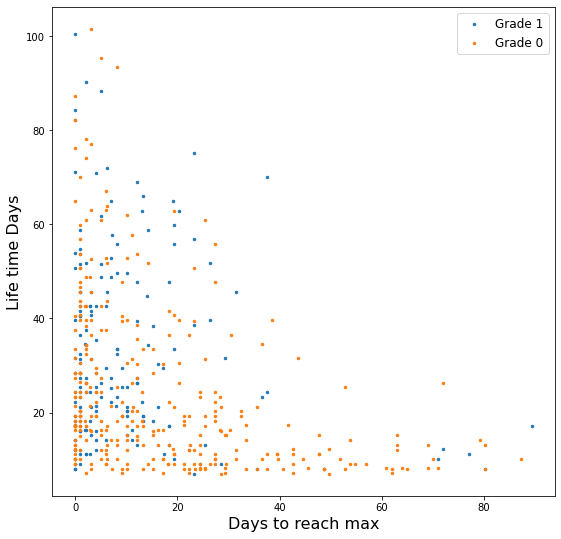

In [48]:
plt.figure(figsize = (9,9))



temp1 = grade1.loc[ grade1['Status'] == True ][['Days_to_glory','Life_time']]
plt.scatter(temp1['Days_to_glory']/30, temp1['Life_time']/30, s = 6, label= 'Grade 1')


temp0 = grade0.loc[ grade0['Status'] == True ][['Days_to_glory','Life_time']]
plt.scatter(temp0['Days_to_glory']/30, temp0['Life_time']/30, s = 6, label = 'Grade 0')
plt.legend(fontsize=12)




plt.xlabel("Days to reach max", fontsize = 16)
plt.ylabel("Life time Days", fontsize = 16)

print('The number of death grade 1 games is ', len(temp1))
print('The number of death grade 0 games is ', len(temp0))

print('Games lost due to filtering for grade 1 ', len(grade1) - len(temp1))

print('Games lost due to filtering for grade 0 ', len(grade0) - len(temp0))



